# Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент: | Глушатов И.С. |
|---------|--------|
| Группа:  | М8О-307Б-19      |

Загружаем датасет:

In [12]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [13]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [14]:
data.shape

(42000, 784)

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
print(tf.__version__)

2.8.0


Разбиваем тестовую выборку и нормализуем данные

In [16]:
TrainData, TestData, TrainLabels, TestLabels = train_test_split(
    data, labels, test_size=0.3, shuffle=True
)

TrainData = (TrainData - np.min(TrainData)) / (np.max(TrainData)-np.min(TrainData))
TestData = (TestData - np.min(TestData)) / (np.max(TestData)-np.min(TestData))

In [17]:
TrainData[0, 200:220]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.49411765,
       0.99607843, 0.88235294, 0.04313725, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [18]:
TrainLabels[0:20]

array([6, 7, 0, 6, 3, 7, 7, 9, 5, 1, 3, 3, 2, 4, 5, 1, 9, 3, 1, 7])

In [19]:
def print_results(h, cm):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3))
    axs[0].set_ylim([0, 1])
    axs[0].plot(h.history['accuracy'], "g-", h.history['val_accuracy'], "k--")
    caxes = axs[1].matshow(cm)
    fig.colorbar(caxes)
    fig.suptitle('Result')
    plt.show()

**Однослойный перцептрон, классифицирующий датасет MNIST с точностью >85%, с использованием базового фреймворка**

In [20]:
class LonePerceptron:
    
    def __init__(self, input, output):
        self.input = input
        self.output = output
        self.w = tf.Variable(tf.random.normal(shape=(input, output)))
        self.b = tf.Variable(tf.zeros(shape=(output,)))
        self.history = {i : [] for i in ['loss', 'accuracy', 'val_accuracy']}
    
    def predict(self, x):
        return tf.matmul(x, self.w) + self.b
    
    def train(self, TrainData, TrainLabels, learning_rate, butch, epochs, val = None):
        
        dataset = tf.data.Dataset.from_tensor_slices((TrainData.astype(np.float32), TrainLabels.astype(np.float32)))
        dataset = dataset.shuffle(buffer_size = 1024).batch(butch)
        features = tf.constant(TrainData, dtype=tf.float32)
        labels = tf.constant(TrainLabels, dtype=tf.float32)
        test_features = tf.constant(TestData, dtype=tf.float32)
        test_labels = tf.constant(TestLabels, dtype=tf.float32)
        
        for epoch in range(epochs):
            for xx, yy in dataset:
                x = tf.reshape(xx,(-1, self.input))
                y = tf.one_hot(yy.numpy(), self.output)
                with tf.GradientTape() as tape:
                    predictions = tf.matmul(x, self.w) + self.b
                    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = predictions))
                    dloss_dw, dloss_db = tape.gradient(loss, [self.w, self.b])
                self.w.assign_sub(learning_rate * dloss_dw)
                self.b.assign_sub(learning_rate * dloss_db)
                
            acc = self.get_acc(features, tf.cast(labels, dtype= tf.int64))
            val_acc = self.get_acc(test_features, tf.cast(test_labels, dtype= tf.int64)) if val != None else None
            self.history['loss'].append(float(loss))
            self.history['accuracy'].append(float(acc))
            self.history['val_accuracy'].append(float(val_acc))
            
            print('Epoch %d: last batch loss = %.4f accuracy = %.4f' % (epoch, float(loss), float(acc)))
    
    @tf.function
    def get_acc(self, x, y):
        p = self.predict(x)
        pred = tf.math.argmax(p, 1)
        acc = tf.reduce_mean(tf.cast(pred == y, dtype = tf.float32))
        return acc

In [21]:
LP = LonePerceptron(784, 10)
LP.train(TrainData, TrainLabels, 0.1, 8, 7, val = (TestData, TestLabels))

Epoch 0: last batch loss = 0.2757 accuracy = 0.7054
Epoch 1: last batch loss = 0.3871 accuracy = 0.7886
Epoch 2: last batch loss = 0.2278 accuracy = 0.8196
Epoch 3: last batch loss = 0.0337 accuracy = 0.8358
Epoch 4: last batch loss = 0.1512 accuracy = 0.8473
Epoch 5: last batch loss = 0.0558 accuracy = 0.8550
Epoch 6: last batch loss = 0.1368 accuracy = 0.8613


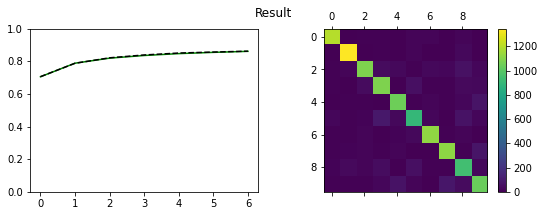

In [22]:
CM = tf.math.confusion_matrix(tf.constant(TestLabels, dtype=tf.float32), 
                              tf.math.argmax(LP.predict(tf.constant(TestData, dtype=tf.float32)), 1))
print_results(LP, CM)

**Однослойный перцептрон, классифицирующий датасет MNIST с точностью >85%**

In [23]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10, activation='softmax', input_shape=(784,)))

model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
model.summary()
h = model.fit(TrainData, TrainLabels, validation_data = (TestData,TestLabels), batch_size=8, epochs=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
3675/3675 [==============================] - 4s 1ms/step - loss: 0.4472 - accuracy: 0.8795 - val_loss: 0.3245 - val_accuracy: 0.9102
Epoch 2/8
3675/3675 [==============================] - 4s 1ms/step - loss: 0.2963 - accuracy: 0.9153 - val_loss: 0.3053 - val_accuracy: 0.9141
Epoch 3/8
3675/3675 [==============================] - 4s 1ms/step - loss: 0.2738 - accuracy: 0.9218 - val_loss: 0.2987 - val_accuracy: 0.9141
Epoch 4/8
3675/3675 [==============================] - 4s 1ms/step - loss: 0.2620 - accuracy: 0.9252 - val_loss: 0.2895 - val_accuracy: 0.9206
Epoch 5/8


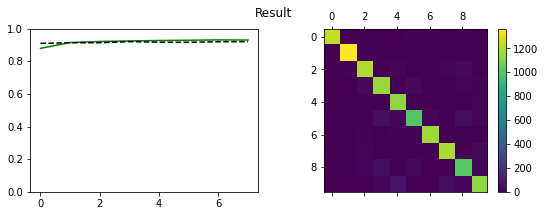

In [24]:
CM = tf.math.confusion_matrix(TestLabels, model.predict(TestData).argmax(axis=1))
print_results(h, CM)

**Многослойный перцептрон, классифицирующий датасет MNIST с точностью >85%**

В качестве передаточной функции выступает ReLU

In [25]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(300, activation = 'relu', input_shape=(784,)))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
model.summary()
h = model.fit(TrainData, TrainLabels, validation_data = (TestData,TestLabels), batch_size=8, epochs=3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 300)               235500    
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
3675/3675 [==============================] - 7s 2ms/step - loss: 0.2455 - accuracy: 0.9238 - val_loss: 0.1430 - val_accuracy: 0.9562
Epoch 2/3
3675/3675 [==============================] - 7s 2ms/step - loss: 0.1074 - accuracy: 0.9667 - val_loss: 0.1481 - val_accuracy: 0.9571
Epoch 3/3
3675/3675 [=====

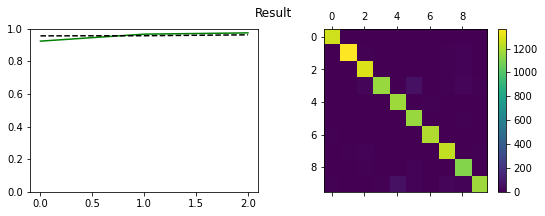

In [26]:
CM = tf.math.confusion_matrix(TestLabels, model.predict(TestData).argmax(axis=1))
print_results(h, CM)

**Сравнение гиперпараметров: передаточная функция**

Сравнение передаточных функций гиперболического тангенса, ReLU и сигмоиды на многослойном перцептроне

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                15700     
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________


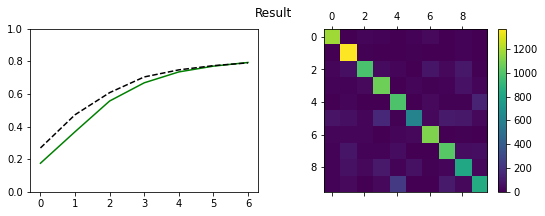

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                15700     
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________


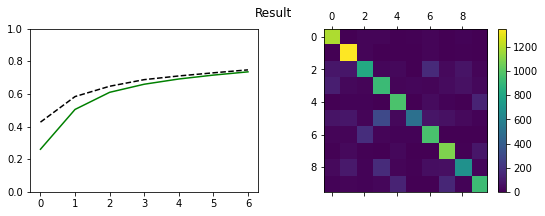

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                15700     
                                                                 
 dense_9 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________


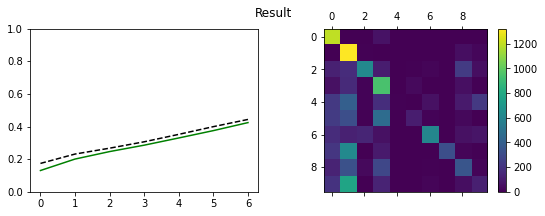

In [27]:
for fun in ['relu', 'tanh', 'sigmoid']:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(20, activation = fun, input_shape=(784,)))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(tf.keras.optimizers.SGD(learning_rate=0.001), 'sparse_categorical_crossentropy', ['accuracy'])
    model.summary()
    h = model.fit(TrainData, TrainLabels, validation_data = (TestData,TestLabels), batch_size=64, epochs=7, verbose=0)
    CM = tf.math.confusion_matrix(TestLabels, model.predict(TestData).argmax(axis=1))
    print_results(h, CM)

Можно увидеть, что ReLU и Tanh работают примерно одинакого, в то время как сигмоида проявляет себя хуже всего.

**Сравнение гиперпараметров: число нейронов в промежуточных слоях**

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 2)                 1570      
                                                                 
 dense_11 (Dense)            (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


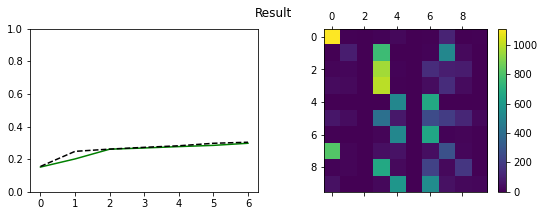

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 3)                 2355      
                                                                 
 dense_13 (Dense)            (None, 10)                40        
                                                                 
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________


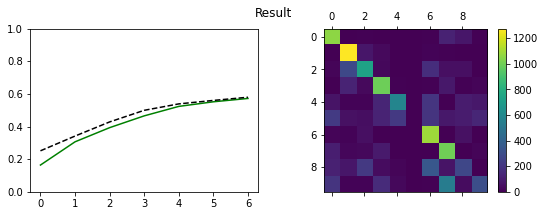

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 4)                 3140      
                                                                 
 dense_15 (Dense)            (None, 10)                50        
                                                                 
Total params: 3,190
Trainable params: 3,190
Non-trainable params: 0
_________________________________________________________________


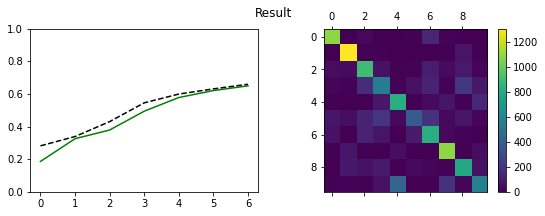

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 5)                 3925      
                                                                 
 dense_17 (Dense)            (None, 10)                60        
                                                                 
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


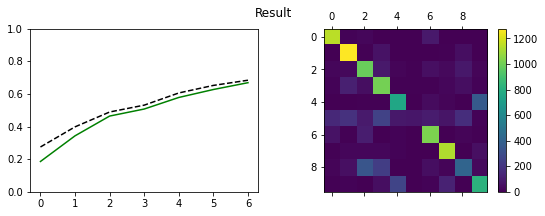

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                7850      
                                                                 
 dense_19 (Dense)            (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


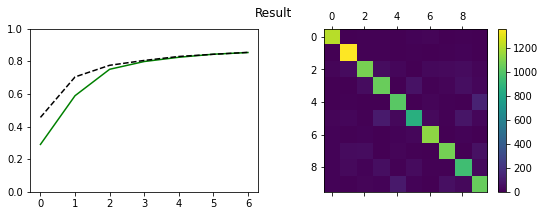

In [28]:
for n in [2, 3, 4, 5, 10]:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(n, activation = 'relu', input_shape=(784,)))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(tf.keras.optimizers.SGD(learning_rate=0.001), 'sparse_categorical_crossentropy', ['accuracy'])
    model.summary()
    h = model.fit(TrainData, TrainLabels, validation_data = (TestData,TestLabels), batch_size=16, epochs=7, verbose=0)
    CM = tf.math.confusion_matrix(TestLabels, model.predict(TestData).argmax(axis=1))
    print_results(h, CM)

Чётко видно, как при увеличении количества нейронов в промежуточном слое, результат улучшается.

**Сравнение гиперпараметров: функция потерь**

Сравнение кросс-энтропии, среднеквадратической и среднеабсолютной функций потерь на многослойном перцептроне с передаточной функцией ReLU

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                7850      
                                                                 
 dense_21 (Dense)            (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


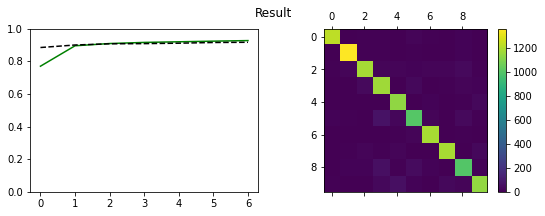

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 10)                7850      
                                                                 
 dense_23 (Dense)            (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


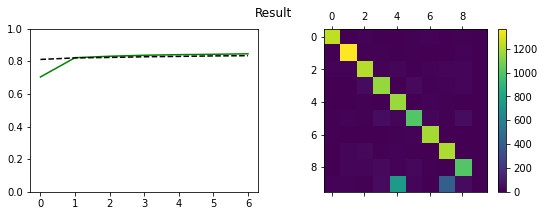

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                7850      
                                                                 
 dense_25 (Dense)            (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


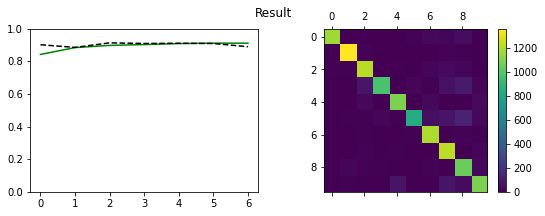

In [29]:
for lf in [tf.keras.losses.MSE, tf.keras.losses.MAE, 'categorical_crossentropy']:
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(10, activation = 'relu', input_shape=(784,)))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), lf, ['accuracy'])
    model.summary()
    h = model.fit(TrainData, tf.one_hot(TrainLabels, 10), validation_data = (TestData, tf.one_hot(TestLabels, 10)), batch_size=4, epochs=7, verbose=0)
    CM = tf.math.confusion_matrix(TestLabels, model.predict(TestData).argmax(axis=1))
    print_results(h, CM)

По результатам MSE и Cross-Entropy работают чуть лучше, чем MAE.

### Fashion MNIST

In [38]:
from utils import mnist_reader
TrainData, TrainLabels = mnist_reader.load_mnist('data/fashion', kind='train')
TestData, TestLabels = mnist_reader.load_mnist('data/fashion', kind='t10k')

TrainData = (TrainData - np.min(TrainData)) / (np.max(TrainData)-np.min(TrainData))
TestData = (TestData - np.min(TestData)) / (np.max(TestData)-np.min(TestData))

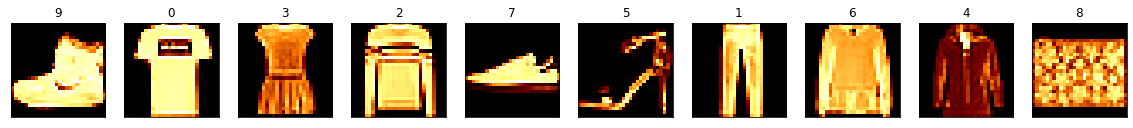

In [39]:
fig = plt.figure(figsize=(20, 5))

checked = []
k = 1
for i in range(0, len(TrainData)):
    if TrainLabels[i] not in checked:
        ax = fig.add_subplot(1, 10, k)
        k += 1
        plt.imshow(TrainData[i].reshape(28,28), cmap='afmhot')
        plt.title(TrainLabels[i])
        ax.set_xticks([])
        ax.set_yticks([])
        checked.append(TrainLabels[i])

plt.show()

In [40]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(300, activation = 'relu', input_shape=(784,)))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
model.summary()
h = model.fit(TrainData, TrainLabels, validation_data = (TestData,TestLabels), batch_size=8, epochs=3)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 300)               235500    
                                                                 
 dense_27 (Dense)            (None, 100)               30100     
                                                                 
 dense_28 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
7500/7500 [==============================] - 15s 2ms/step - loss: 0.4781 - accuracy: 0.8266 - val_loss: 0.4379 - val_accuracy: 0.8419
Epoch 2/3
7500/7500 [==============================] - 14s 2ms/step - loss: 0.3647 - accuracy: 0.8653 - val_loss: 0.3821 - val_accuracy: 0.8668
Epoch 3/3
7500/7500 [==

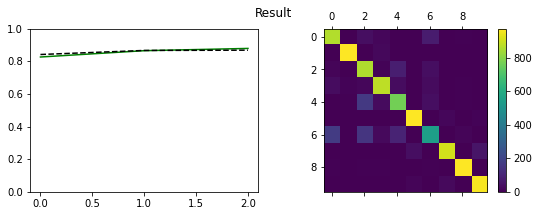

In [41]:
CM = tf.math.confusion_matrix(TestLabels, model.predict(TestData).argmax(axis=1))
print_results(h, CM)

Результаты на Fashion MNIST аналогичны результатам первой части лабораторной.

### CIFAR-10

In [43]:
(TrainData, TrainLabels), (TestData, TestLabels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 510s 3us/step


In [47]:
TrainData = (TrainData - np.min(TrainData)) / (np.max(TrainData)-np.min(TrainData))
TestData = (TestData - np.min(TestData)) / (np.max(TestData)-np.min(TestData))

In [50]:
TrainData.shape

(50000, 32, 32, 3)

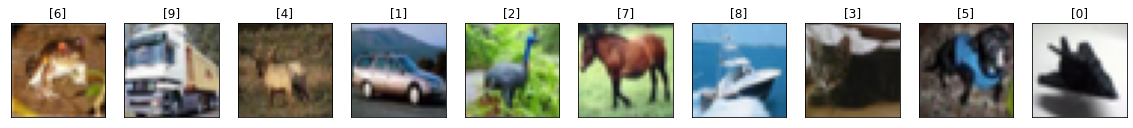

In [55]:
fig = plt.figure(figsize=(20, 5))

checked = []
k = 1
for i in range(0, len(TrainData)):
    if TrainLabels[i] not in checked:
        ax = fig.add_subplot(1, 10, k)
        k += 1
        plt.imshow(TrainData[i].reshape(32, 32, 3))
        plt.title(TrainLabels[i])
        ax.set_xticks([])
        ax.set_yticks([])
        checked.append(TrainLabels[i])

plt.show()

In [56]:
TrainData[0].shape

(32, 32, 3)

In [75]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='tanh', input_shape=(32, 32, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='tanh'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
model.summary()
h = model.fit(TrainData, TrainLabels, validation_data = (TestData,TestLabels), batch_size=32, epochs=10)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_59 (Dense)            (None, 512)               4194816   
                                                                 
 dense_60 (Dense)            (None, 256)               131328    
                                                                 
 dense_61 (Dense)            (None, 128)               32896     
                                                     

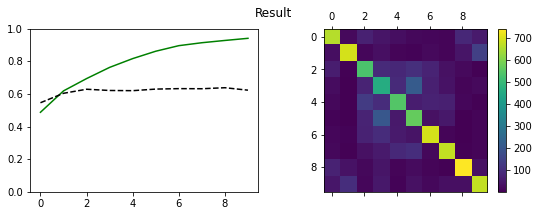

In [76]:
CM = tf.math.confusion_matrix(TestLabels, model.predict(TestData).argmax(axis=1))
print_results(h, CM)

На цветных картинках обычная нейросеть обучается хуже, нежели чем на монотонных. Мы видим, что сеть на тренировочных данных легко доходит до 94-95% точности результата, однако на тестовых точность стабильно крутится около 60%. 
Судя по матрице неточности можно заметить, что очень часто сеть путает собак (5) и кошек (3). Да и в принципе с 2 по 6 классы изображения нейросеть очень плохо различает, а именно различных животных. Также можно увидеть, что путуются грузовики (9) с авто (1) и корабли (8) с самолетами (0). При этом нейросеть достаточно редко относит неодушевленные предметы к одушевленным и наоборот.